# A new definition of hitting time and an embedded Markov chain in continuous-time quantum walks

Comparison between two methods to compute our proposed hitting time of a CTQW in a 4x4 grid, and compare empirically the definition of the hitting times worked here and in Varbanov et al. (2008)  through simulations of both measured CTQWs.

We studied the hitting time of a measured CTQW to a set of vertices F; doing measurements every random time determined by a Poisson process

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import expm_multiply
from scipy.sparse.linalg import expm
from scipy.stats import expon
import pandas as pd
import json
import time
import gc
import random
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_DIR = "/content/drive/My Drive/hitting_time_paper/"

# Functions

Function to obtain the Hamiltonian associated to a given graph and the transition rate

In [ ]:
def giveMeHamiltonian(G, gamma, typeMatrix="laplacian"):
  # typeMatrix could be "adjacency" to use the adjacency matrix based Hamiltoninan 
  # or "laplacian" (default) to use the Laplacian matrix based Hamiltonian
  # gamma is the mutation rate 

  if typeMatrix == "adjacency":
    A = nx.adjacency_matrix(G)
  else:
    A = nx.laplacian_matrix(G)

  H = -gamma* A

  return H

Function to calculate the i-th canonical vector in $C^n$

In [ ]:
def canonical_vector(i, n):
  # i-esimo vector canonico en C^n
  ei = np.zeros(n)
  ei[i] = 1.0
  return ei

Function to simulate a measurement with respect to the canonical basis of the quantum walk

In [ ]:
def measurement_basis(state, basis):
  # state is a vector in C^N

  qprobs = [abs(state[v])**2 for v in basis]
  collapse = np.random.choice(basis, p=qprobs)

  return collapse

Projection of a state to the genereted space by nodes in $F$

In [ ]:
def projection_to_F(state, F):
  state_pr = np.array([state[v] if v in F else 0 for v in range(len(state))])
  return state_pr

Function to simulate a measurement to check whether the system is in one of the final states $|v \rangle $, $v\in F\subset V$. The corresponding measurment operators are $$\{P_v:= |v\rangle \langle v| \; |\; v\in F\}\cup\{Q:=I - \sum_{v\in F}P_v\}$$

In [ ]:
def measurement_in_F(state, F):
  # weak measurement to check if state is in F or not
  outcomes = list(F).copy()
  outcomes.append(-1) # -1 means state is not in F
  qprobs = [abs(state[v])**2 for v in outcomes if v != -1]
  qprobs.append(1-np.sum(qprobs))

  collapse = np.random.choice(outcomes, p=qprobs)

  if collapse == -1:
    post_state = state - projection_to_F(state, F)
    post_state = post_state/np.linalg.norm(post_state)
  else:
    post_state = canonical_vector(collapse, len(state))

  return collapse, post_state

In [ ]:
# function to estimate the transition matrix of the Markov chain obtained by the measurement results (when measurements are with respect the canonical basis)

def estimateTransitionMatrix(H, measurement_rate, N):
  # H is the Hamiltonian of the quantum walk
  # N is the number of realizations of the exponential random variable that determines the time at which we measure the quantum walk
  
  M = H.shape[0]

  times = expon.rvs(scale=1/measurement_rate, size=N)
  
  expected_matrix = np.zeros((M, M))

  computed_times = np.zeros(N)

  for k, t in enumerate(times):
    start = time.time()

    evolution_matrix = expm(-1j*t*H)

    for i in range(M):
      for j in range(M):
        expected_matrix[i, j] += abs(evolution_matrix[i,j])**2

    end = time.time()

    del evolution_matrix
    gc.collect()

    computed_times[k] = end-start
  
  expected_matrix = expected_matrix/N

  print("Average time =", computed_times.mean())

  return expected_matrix, computed_times

In [11]:
# hitting time (mean first passage time) to F of a discrete Markov chain 
def computeHittingTimes_d(transition_matrix, F):

  A = np.delete(transition_matrix, F, axis=0)
  A = np.delete(A, F, axis = 1)
  A = A - np.identity(A.shape[0])

  b = np.array([-1 for i in range(transition_matrix.shape[0] - len(F))])

  x = np.linalg.solve(A, b)

  for i in F:
    # F it is supposed to be ordered
    x = np.insert(x, i, 0)

  return x

In [ ]:
# hitting time to F of a continuous quantum walk
def computeHittingTimes_q(hamiltonian, measurement_rate, F, N=500):
  T = estimateTransitionMatrix(hamiltonian, measurement_rate, N)
  return (1/measurement_rate)*computeHittingTimes_d(T, F)

In [ ]:
def continuousQuantumWalk(graph, marked_nodes, initial_state, gamma, measurement_rate, max_simulation_time, is_measurement_basis=True):
  finded = False

  M = graph.order()

  H = -gamma*nx.laplacian_matrix(graph).toarray()

  no_measurement = 0
  total_jumps = 0
  time = 0
 
  actual_state = initial_state 
  actual_state_vec = canonical_vector(actual_state, M) # vector representing genotype actual_state

  # Start of simulation
  while time < max_simulation_time:
    if actual_state in marked_nodes: # if we find one of the marked nodes
      finded = True
      break
      
    T = expon.rvs(scale=1/measurement_rate, size=1)[0] # time between measurements
    time += T
    
    # evolving quantum walk
    actual_state_vec = expm_multiply(-1j*T*H, actual_state_vec) # evolve quantum walk until time T with actual_state as initial state

    if is_measurement_basis:
      measurement_result = measurement_basis(actual_state_vec, graph.nodes)
      actual_state_vec = canonical_vector(measurement_result, M)
    else:
      measurement_result, actual_state_vec = measurement_in_F(actual_state_vec, marked_nodes)

    no_measurement += 1

    if measurement_result != actual_state:
      total_jumps += 1 # total number of jumps do not say anything in the case of weak measurements. It always will be 2 jumps.

    actual_state = measurement_result
      
  # End of simulation
  
  simulations_results_aux = {'initial state': initial_state, 'transition rate': gamma, 'measurement rate': measurement_rate, 'simulation time': time, 
                             'total measurements': no_measurement, 'total jumps': total_jumps, 'finded': finded}

  return simulations_results_aux

# Simulation parameters

In [13]:
F = [12, 14, 15] # marked nodes
measurement_rate = 0.5
gamma_q = 0.1
max_simulation_time = 3000
initial_node = 0 

# Simulations

In [ ]:
G = nx.Graph()
G.add_nodes_from([i for i in range(16)])
G.add_edges_from([(0,1), (0,2), (1, 3), (1, 4), (2, 4), (2, 5), (3,6), (3,7), (4, 7), (4, 8), (5, 8), (5, 9), 
                  (6, 10), (7, 10), (7, 11), (8, 11), (8, 12), (9, 12), (10, 13), (11, 13), (11, 14), (12, 14), 
                  (13, 15), (14, 15)])

H = -gamma_q*nx.laplacian_matrix(G).toarray() # Hamiltonian

# colors of nodes
color_map = []
for v in G:
  if v == initial_node:
    color_map.append("green")
  elif v in F:
    color_map.append("red")
  else:
    color_map.append("blue")

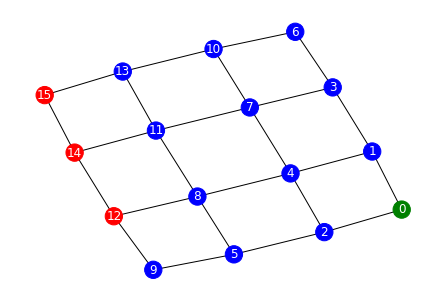

In [ ]:
nx.draw(G, with_labels=True, node_color=color_map, font_color='white')

In [ ]:
initial_simulation = 0
final_simulation = 10

In [ ]:
for num_simulation in range(initial_simulation, final_simulation + 1):
    results_qw = pd.DataFrame()
    # WARNING: long execution. Simulations considering our proposed hitting time
    for i in range(2000):
      results_qw = results_qw.append(
          continuousQuantumWalk(
              graph=G, 
              marked_nodes = F, 
              initial_state=initial_node, 
              gamma=gamma_q, 
              measurement_rate=measurement_rate, 
              max_simulation_time=max_simulation_time
              ), 
              ignore_index=True)
      
      results_qw.to_csv(BASE_DIR + f"experiment_results_{num_simulation}.csv")

In [ ]:
for num_simulation in range(initial_simulation, final_simulation + 1):
    results_qw_varbanov = pd.DataFrame()
    # WARNING: long execution. Simulations considering hitting time proposed in Varbanov et al. (2018)
    for i in range(2000):
      results_qw_varbanov = results_qw_varbanov.append(
          continuousQuantumWalk(
              graph=G, 
              marked_nodes = F, 
              initial_state=initial_node, 
              gamma=gamma_q, 
              measurement_rate=measurement_rate, 
              max_simulation_time=max_simulation_time,
              is_measurement_basis=False
            ), 
          ignore_index=True)
      
      results_qw_varbanov.to_csv(BASE_DIR + f"experiment_results_varbanov_{num_simulation}.csv")

# Analysis

In [5]:
results_qw = pd.read_csv(BASE_DIR + "experiment_results_0.csv", index_col=0)
results_qw_varbanov = pd.read_csv(BASE_DIR + "experiment_results_varbanov_0.csv", index_col=0)

In [6]:
results_qw

,measurement rate,finded,initial state,simulation time,total jumps,total measurements,transition rate
0,0.5,1.0,0.0,487.333820,33.0,221.0,0.1
1,0.5,1.0,0.0,249.736517,21.0,108.0,0.1
2,0.5,1.0,0.0,131.682535,9.0,46.0,0.1
3,0.5,1.0,0.0,126.648172,10.0,73.0,0.1
4,0.5,1.0,0.0,81.469035,4.0,44.0,0.1
...,...,...,...,...,...,...,...
1995,0.5,1.0,0.0,140.670156,13.0,80.0,0.1
1996,0.5,1.0,0.0,271.232774,21.0,133.0,0.1
1997,0.5,1.0,0.0,406.150039,31.0,185.0,0.1
1998,0.5,1.0,0.0,105.350928,11.0,57.0,0.1


In [7]:
results_qw_varbanov

,initial state,transition rate,measurement rate,simulation time,total measurements,total jumps,finded
0,0.0,0.1,0.5,18.398238,11.0,2.0,1.0
1,0.0,0.1,0.5,121.601040,62.0,2.0,1.0
2,0.0,0.1,0.5,211.916704,110.0,2.0,1.0
3,0.0,0.1,0.5,695.103422,337.0,2.0,1.0
4,0.0,0.1,0.5,16.188688,8.0,2.0,1.0
...,...,...,...,...,...,...,...
1995,0.0,0.1,0.5,107.648308,63.0,2.0,1.0
1996,0.0,0.1,0.5,366.341697,195.0,2.0,1.0
1997,0.0,0.1,0.5,234.857842,127.0,2.0,1.0
1998,0.0,0.1,0.5,55.743001,24.0,2.0,1.0


### Obtaining hitting times using formula

In [8]:
# WARNING: long execution. Estimation of transition matrix of the Markov chain obtained with the measurements outcomes

#T, compute_times = estimateTransitionMatrix(H, measurement_rate, N=5000)
#T.save(BASE_DIR + "estimated_transition_matrix.npy")

In [9]:
T = np.load(BASE_DIR + "estimated_transition_matrix.npy")

In [19]:
hitting_times_qd = computeHittingTimes_d(T, F)

In [20]:
hitting_times_qd

array([96.17544923, 94.64284947, 85.40828351, 92.70133192, 82.25930956,
       66.08042589, 91.49158971, 79.11145707, 56.27784158, 46.46794966,
       77.49085966, 50.94940538,  0.        , 49.09342077,  0.        ,
        0.        ])

In [21]:
hitting_times_q = (1/measurement_rate)*hitting_times_qd
hitting_times_q

array([192.35089847, 189.28569895, 170.81656701, 185.40266385,
       164.51861912, 132.16085177, 182.98317941, 158.22291414,
       112.55568316,  92.93589931, 154.98171933, 101.89881076,
         0.        ,  98.18684154,   0.        ,   0.        ])

### Comparison

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
print("Number of simulations:", len(results_qw))
print("Average of number of measurements:", results_qw['total measurements'].mean())
print("Average of hitting times:", results_qw['simulation time'].mean())
print("\nExpected hitting time:", hitting_times_q[initial_node])
print("\nStandard deviation")
print("Standard deviation of number of measurements:", results_qw['total measurements'].std())
print("Standard deviation of hitting times:", results_qw['simulation time'].std())

Number of simulations: 2000
Average of number of measurements: 94.0085
Average of hitting times: 188.43911488256413

Expected hitting time: 192.35089846983217

Standard deviation
Standard deviation of number of measurements: 79.07772170962814
Standard deviation of hitting times: 155.62515413622125


In [24]:
print("Number of simulations:", len(results_qw_varbanov))
print("Average of number of measurements:", results_qw_varbanov['total measurements'].mean())
print("Average of hitting times:", results_qw_varbanov['simulation time'].mean())
print("\nStandard deviation")
print("Standard deviation of number of measurements:", results_qw_varbanov['total measurements'].std())
print("Standard deviation of hitting times:", results_qw_varbanov['simulation time'].std())

Number of simulations: 2000
Average of number of measurements: 66.704
Average of hitting times: 133.14482234155923

Standard deviation
Standard deviation of number of measurements: 80.52825456876577
Standard deviation of hitting times: 157.782912011008


In [25]:
results_qw["Definition"] = "Ruiz et al."
results_qw_varbanov["Definition"] = "Varbanov et al. (2008)"
all_hitting_times = pd.concat([results_qw[["Definition", "simulation time"]], results_qw_varbanov[["Definition", "simulation time"]]], ignore_index=True)
all_hitting_times.rename(columns={"simulation time": "Hitting times"}, inplace=True)

In [26]:
all_hitting_times

,Definition,Hitting times
0,Ruiz et al.,487.333820
1,Ruiz et al.,249.736517
2,Ruiz et al.,131.682535
3,Ruiz et al.,126.648172
4,Ruiz et al.,81.469035
...,...,...
3995,Varbanov et al. (2008),107.648308
3996,Varbanov et al. (2008),366.341697
3997,Varbanov et al. (2008),234.857842
3998,Varbanov et al. (2008),55.743001


In [27]:
plt.rcParams.update({'font.size': 15}) # fontsize of charts

[]

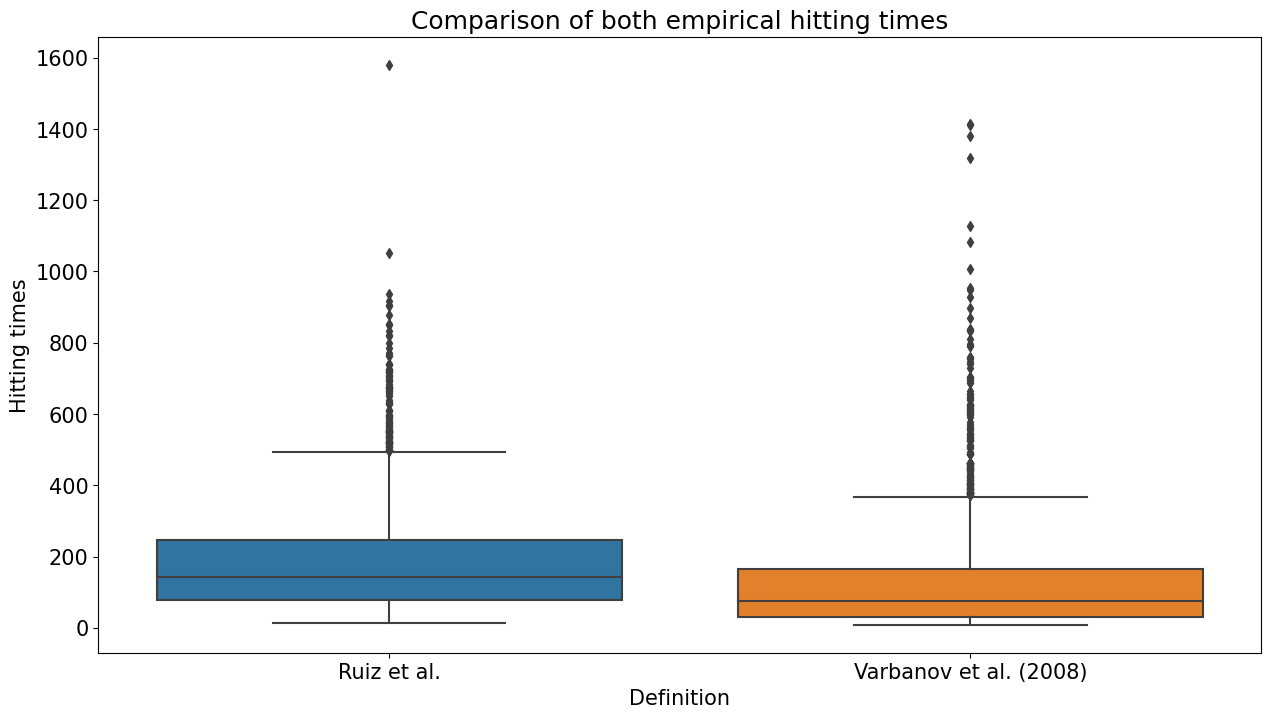

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x="Definition", y="Hitting times", data=all_hitting_times, ax=ax)
ax.set_title("Comparison of both empirical hitting times")
plt.savefig(BASE_DIR + "hitting_times_comparison.png")
plt.plot()

In [29]:
from scipy import stats

test = stats.mannwhitneyu(x=all_hitting_times[all_hitting_times["Definition"] == "Ruiz et al."]["Hitting times"], y=all_hitting_times[all_hitting_times["Definition"] == "Varbanov et al. (2008)"]["Hitting times"], alternative='greater')
test

MannwhitneyuResult(statistic=2664953.0, pvalue=2.2216488833049793e-74)